In [ ]:
!pip install -r requirements.txt

# Download UIT-ViIC dataset

Chạy lệnh sau để tải dữ liệu:
`python download_uitvic.py`

# VietSGG

In [ ]:
import os
import io
import re
import json
import math
import base64
import logging
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any, Optional

from PIL import Image
from tqdm import tqdm

import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from openai import OpenAI

# Logging (DEBUG -> file)

In [ ]:
# =========================
# Logging (DEBUG -> file)
# =========================
os.makedirs("./logs", exist_ok=True)
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    handlers=[
        logging.FileHandler("./logs/pipeline_debug.log", encoding="utf-8"),
        logging.StreamHandler()
    ],
)
logger = logging.getLogger("SGG-Pipeline")

# Configs & Constants

In [ ]:
# =========================
# Configs & Constants
# =========================
@dataclass
class Config:
    img_dir: str = "/datasets/coco_uitvic_train"
    output_rel_path: str = "relationships_vi_coco_uitvic_train.json"
    output_det_path: str = "detections_cache_coco_uitvic_train.json"      # lưu phát hiện để tái sử dụng
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # GroundingDINO
    # gd_model_id: str = "IDEA-Research/grounding-dino-base"
    gd_model_id: str = "rziga/mm_grounding_dino_large_all"

    text_threshold: float = 0.4 #0.25
    score_threshold: float = 0.35 #0.30
    nms_iou_threshold: float = 0.5

    # Prompt labels
    # === Semantic grouping===
    group_chunk_size: int = 9  # chạy GDINO theo nhóm nhãn để giảm lẫn
    label_groups: Dict[str, List[str]] = field(default_factory=lambda: {
        # Nhóm người & vai trò
        "PEOPLE": [
            "player", "referee", "coach", "kid", "audience",
        ],
        # Nhóm bóng & dụng cụ cầm tay
        "BALLS_GEARS": [
            "soccer ball", "basketball", "volleyball", "tennis ball", "baseball",
            "tennis racket", "baseball bat", "baseball glove", "whistle"
        ],
        # Nhóm sân bãi & thiết bị cố định
        "ENV": [
            "soccer field", "tennis court", "basketball hoop", "baseball field", "rugby field", "goal", "net", "scoreboard", "volleyball court"
        ],
        # Nhóm trang phục (giảm đồng nghĩa để đỡ nhiễu)
        "WEAR": [
            "uniform", "shoes"
        ],
        # Nhóm động vật thi đấu
        "ANIMAL":[
            "horses", "elephant"
        ]
    })
    group_order: List[str] = field(default_factory=lambda: ["PEOPLE", "BALLS_GEARS", "ENV", "WEAR", "ANIMAL"])

    force_redetect: bool = True # True nếu không dùng detect đã lưu

    # OpenAI
    gpt_model_vision: str = "gpt-4.1"          # dùng cho caption/quan hệ
    gpt_model_text: str = "gpt-4.1-mini"       # dùng cho dịch/nhẹ; có thể thay bằng 3.5 nếu muốn
    # openai_api_key_env: str = "API_KEY"

    # Quan hệ
    max_relations: int = 6

    # Cache GPT
    cache_path: str = "./gpt_cache_coco_uitvic_train.json"  # cache đơn giản đầu vào->đầu ra

    # Từ điển vị từ EN->VI (ưu tiên)
    predicate_map_en_vi: Dict[str, str] = field(default_factory=lambda: {
        "holding": "cầm",
        "kicking": "đá",
        "throwing": "ném",
        "catching": "bắt",
        "hit": "đánh",
        "riding": "cưỡi",
        "wearing": "đeo",
        "standing on": "đứng trên",
        "sitting on": "ngồi trên",
        "next to": "bên cạnh",
        "in front of": "phía trước",
        "behind": "phía sau",
        "near": "gần",
        "far from": "xa",
        "touching": "chạm",
        "guarding": "kèm",
        "dribbling": "dẫn bóng",
        "shooting": "sút/ném",
        "passing": "chuyền",
        "looking at": "nhìn vào",
        "celebrating": "ăn mừng",
        "blocking": "chắn",
        "swing": "vung",
        "swung": "vung",
    })

    # Từ điển EN->VI cho đối tượng cố định (tiền dịch sẵn)
    object_dict_en_vi: Dict[str, str] = field(default_factory=lambda: {
        "player": "vận động viên",
        "referee": "trọng tài",
        "coach": "huấn luyện viên",
        "kid": "trẻ em",
        "audience": "khán giả",
        "soccer ball": "quả bóng đá",
        "basketball": "quả bóng rổ",
        "volleyball": "quả bóng chuyền",
        "tennis ball": "quả bóng tennis",
        "rugby ball": "quả bóng bầu dục",
        "baseball": "bóng chày",
        "tennis racket": "vợt tennis",
        "baseball bat": "gậy bóng chày",
        "baseball glove": "găng bóng chày",
        "whistle": "còi",
        "scoreboard": "bảng tỉ số",
        "goal": "khung thành",
        "net": "lưới",
        "basketball hoop": "rổ bóng rổ",
        "tennis court": "sân tennis",
        "soccer field": "sân bóng đá",
        "baseball field": "sân bóng chày",
        "volleyball field": "sân bóng chuyền",
        "rugby court": "sân bóng bầu dục",
        "sportswear": "đồ thể thao",
        # "jersey": "áo đấu",
        "uniform": "đồng phục",
        "shoes": "giày",
        "horses": "ngựa",
        "elephant": "voi",
    })

# ==== Ontology & label normalization helpers ====

In [ ]:
# ==== Ontology & label normalization helpers ====
CANONICALS = {
    # people
    "player": ["player", "athlete"],
    "referee": ["referee", "umpire"],
    "coach": ["coach"],
    "kid": ["kid", "child"],
    "audience": ["audience", "crowd", "spectator"],
    # balls
    "soccer ball": ["soccer ball", "football (soccer ball)"],
    "basketball": ["basketball"],
    "volleyball": ["volleyball"],
    "tennis ball": ["tennis ball"],
    "baseball": ["baseball"],
    # gears
    "tennis racket": ["tennis racket", "racket"],
    "baseball bat": ["baseball bat", "bat"],
    "baseball glove": ["baseball glove", "glove"],
    "whistle": ["whistle"],
    # field/court/goals
    "goal": ["goal"],
    "net": ["net"],
    "basketball hoop": ["basketball hoop", "rim"],
    "tennis court": ["tennis court"],
    "soccer field": ["soccer field", "football pitch"],
    # wear
    "sportswear": ["sportswear"],
    "jersey": ["jersey"],
    "uniform": ["uniform"],
    "shoes": ["shoes", "sneakers", "cleats"],
    # crowd big region (optional)
    "scoreboard": ["scoreboard"],
    "bench": ["bench"],
}

# Build reverse alias->canonical
ALIAS2CANON = {}
for cano, aliases in CANONICALS.items():
    for a in aliases:
        ALIAS2CANON[a.lower()] = cano

# Utilities

In [ ]:
# =========================
# Utilities
# =========================
def pil_to_base64_png(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{b64}"


def torchvision_nms(boxes, scores, iou_threshold=0.5):
    if len(boxes) == 0:
        return []
    t_boxes = torch.tensor(boxes, device="cpu", dtype=torch.float32)
    t_scores = torch.tensor(scores, device="cpu", dtype=torch.float32)
    # Nếu có torchvision, xài thẳng; nếu không có, fallback đơn giản
    try:
        keep_idx = torch.ops.torchvision.nms(t_boxes, t_scores, iou_threshold)
        return keep_idx.cpu().tolist()
    except Exception as e:
        logger.warning(f"NMS fallback: {e}")
        # Fallback: greedy
        keep = []
        idxs = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        seen = [False] * len(scores)

        def iou(a, b):
            x1 = max(a[0], b[0])
            y1 = max(a[1], b[1])
            x2 = min(a[2], b[2])
            y2 = min(a[3], b[3])
            inter = max(0.0, x2 - x1) * max(0.0, y2 - y1)
            areaA = max(0.0, a[2]-a[0]) * max(0.0, a[3]-a[1])
            areaB = max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])
            union = areaA + areaB - inter + 1e-9
            return inter / union

        for i, idx in enumerate(idxs):
            if seen[idx]:
                continue
            keep.append(idx)
            for j in idxs[i+1:]:
                if not seen[j] and iou(boxes[idx], boxes[j]) >= iou_threshold:
                    seen[j] = True
        return keep


def parse_image_id_from_name(fname: str):
    stem = os.path.splitext(fname)[0]
    m = re.search(r"(\d+)$", stem)
    return int(m.group(1)) if m else stem

# GPT Cache (in-memory + disk)

In [ ]:
# =========================
# GPT Cache (in-memory + disk)
# =========================
class SimpleCache:
    def __init__(self, path: str):
        self.path = path
        self.data: Dict[str, Any] = {}
        if os.path.exists(path):
            try:
                with open(path, "r", encoding="utf-8") as f:
                    self.data = json.load(f)
            except Exception:
                self.data = {}

    def get(self, key: str) -> Optional[Any]:
        return self.data.get(key)

    def set(self, key: str, value: Any):
        self.data[key] = value

    def save(self):
        try:
            with open(self.path, "w", encoding="utf-8") as f:
                json.dump(self.data, f, ensure_ascii=False, indent=2)
        except Exception as e:
            logger.warning(f"Cannot save cache: {e}")

# Translator (with caching)

In [ ]:
# =========================
# Translator (with caching)
# =========================
class Translator:
    def __init__(self, cfg: Config, client: OpenAI, cache: SimpleCache):
        self.cfg = cfg
        self.client = client
        self.cache = cache

    def translate_terms(self, terms: List[str]) -> List[str]:
        """Dịch list EN->VI. Ưu tiên tra từ điển cố định; cache; nếu chưa có, gọi GPT nhẹ."""
        out: List[str] = []
        to_query: List[str] = []
        idx_map: Dict[int, str] = {}

        # Tra trước từ điển cố định + cache
        for i, t in enumerate(terms):
            t_norm = t.strip().lower()
            if t_norm in self.cfg.object_dict_en_vi:
                out.append(self.cfg.object_dict_en_vi[t_norm])
            else:
                key = f"translate::{t_norm}"
                cached = self.cache.get(key)
                if cached:
                    out.append(cached)
                else:
                    idx_map[len(to_query)] = t_norm
                    to_query.append(t_norm)
                    out.append(None)  # placeholder

        if to_query:
            prompt = (
                "Dịch các từ/cụm từ tiếng Anh sau sang tiếng Việt, giữ đúng nghĩa trong ngữ cảnh thể thao. "
                "Chỉ trả về JSON dạng {\"translations\": [\"...\"]}, đúng thứ tự đầu vào."
            )
            key = f"translate_batch::{json.dumps(to_query, ensure_ascii=False)}"
            cached = self.cache.get(key)
            if cached:
                vi_list = cached
            else:
                messages = [
                    {"role": "user", "content": prompt + "\n\n" + json.dumps(to_query, ensure_ascii=False)}
                ]
                try:
                    resp = self.client.chat.completions.create(
                        model=self.cfg.gpt_model_text,
                        messages=messages,
                        max_tokens=256,
                        temperature=0
                    )
                    text_out = (resp.choices[0].message.content or "").strip()
                    js = text_out[text_out.find("{"): text_out.rfind("}") + 1]
                    vi_list = json.loads(js).get("translations", to_query)
                except Exception as e:
                    logger.warning(f"Translate error: {e}")
                    vi_list = to_query  # fallback
                self.cache.set(key, vi_list)

            # Điền vào kết quả + lưu cache đơn lẻ
            vi_idx = 0
            for i in range(len(out)):
                if out[i] is None:
                    vi_term = vi_list[vi_idx] if vi_idx < len(vi_list) else to_query[vi_idx]
                    vi_idx += 1
                    orig = idx_map[vi_idx - 1]
                    self.cache.set(f"translate::{orig}", vi_term)
                    out[i] = vi_term

        return out

# Object Detector (GDINO)


In [ ]:
import difflib

def choose_best_label(raw_label: str, group_prompts: list[str]) -> str:
    """
    Nhận raw_label từ GDINO (có thể là chuỗi ghép) và danh sách prompt của group,
    trả về nhãn canonical gần nhất (EN).
    """
    raw = raw_label.strip().lower()
    tokens = re.split(r"[ ,;/]+", raw)
    # ứng viên chỉ lấy từ prompt của group
    group_norm = [p.strip().lower() for p in group_prompts]
    # nếu nhãn khớp exactly 1 prompt trong group
    if raw in group_norm:
        cand = raw
    else:
        # lấy token dài nhất/ý nghĩa nhất rồi so gần đúng
        focus = " ".join([t for t in tokens if t])[:80]
        cand = difflib.get_close_matches(focus, group_norm, n=1, cutoff=0.4)
        cand = cand[0] if cand else group_norm[0]  # fallback

    # map alias->canonical nếu có
    return ALIAS2CANON.get(cand, cand)


In [ ]:
PEOPLE = {"player","referee","coach","kid","audience"}

PRIORITY = ["referee","player","coach","kid","audience"]  # giữ nhãn ưu tiên cao hơn

def merge_people_cross_label(dets: list[dict], iou_thr=0.6) -> list[dict]:
    people = [d for d in dets if d["label"] in PEOPLE]
    others = [d for d in dets if d["label"] not in PEOPLE]
    if len(people) <= 1:
        return dets

    # sort theo score và theo thứ tự ưu tiên label
    pri_idx = {lb:i for i,lb in enumerate(PRIORITY)}
    people.sort(key=lambda d: (-d["score"], pri_idx.get(d["label"], 999)))

    keep = []
    used = [False]*len(people)

    def _iou(a,b):
        ax1,ay1,ax2,ay2 = a["bbox"]
        bx1,by1,bx2,by2 = b["bbox"]
        x1=max(ax1,bx1); y1=max(ay1,by1); x2=min(ax2,bx2); y2=min(ay2,by2)
        inter=max(0,x2-x1)*max(0,y2-y1)
        areaA=max(0,ax2-ax1)*max(0,ay2-ay1)
        areaB=max(0,bx2-bx1)*max(0,by2-by1)
        union=areaA+areaB-inter+1e-9
        return inter/union

    for i,a in enumerate(people):
        if used[i]: continue
        used[i]=True
        merged=a
        for j,b in enumerate(people):
            if i==j or used[j]: continue
            if _iou(a,b)>=iou_thr:
                # cùng người -> chọn nhãn ưu tiên cao hơn (đã sắp)
                used[j]=True
        keep.append(merged)
    return keep + others

In [ ]:
def filter_shoes(dets: list[dict], img_w: int, img_h: int, min_ratio=0.002, max_keep=4) -> list[dict]:
    area_min = img_w*img_h*min_ratio
    shoes = [d for d in dets if d["label"]=="shoes"]
    others = [d for d in dets if d["label"]!="shoes"]
    if not shoes: return dets
    # giữ những shoes lớn hơn ngưỡng
    shoes = [d for d in shoes if (d["bbox"][2]-d["bbox"][0])*(d["bbox"][3]-d["bbox"][1]) >= area_min]
    # giới hạn số đôi
    shoes.sort(key=lambda d: -d["score"])
    shoes = shoes[:max_keep]
    return others + shoes

In [ ]:
# =========================
# Object Detector (GDINO)
# =========================
class ObjectDetector:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        logger.info("Loading GroundingDINO...")
        self.processor = AutoProcessor.from_pretrained(cfg.gd_model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(cfg.gd_model_id).to(cfg.device)

    def _run_single_prompt(self, img: Image.Image, prompt_labels: List[str]) -> List[Dict[str, Any]]:
        """
        Chạy phát hiện cho 1 nhóm nhãn. Mapping label:
          - Nếu post_process trả về 'text_labels' -> dùng trực tiếp.
          - Nếu chỉ trả 'labels' (index) -> map theo chỉ số vào prompt_labels.
        """
        prompt_text = ". ".join([x.strip() for x in prompt_labels if x.strip()]) + "."
        inputs = self.processor(images=img, text=prompt_text, return_tensors="pt").to(self.cfg.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            text_threshold=self.cfg.text_threshold,
            target_sizes=[img.size[::-1]]
        )[0]

        dets = []
        # Kịch bản 1: có text_labels (phiên bản mới)
        text_labels = results.get("text_labels", None)
        # Kịch bản 2: chỉ có labels (số)
        labels = results.get("labels", [])

        for i, (score, box) in enumerate(zip(results["scores"], results["boxes"])):
            score_f = float(score)
            if score_f < self.cfg.score_threshold:
                continue
            if text_labels is not None:
                label_raw = str(text_labels[i]).strip().lower()
            else:
                # labels[i] là index vào danh sách từ prompt
                try:
                    idx = int(labels[i])
                    label_raw = prompt_labels[idx].strip().lower()
                except Exception:
                    # fallback: chuỗi hóa labels[i]
                    label_raw = str(labels[i]).strip().lower()

            label_canon = choose_best_label(label_raw, prompt_labels)

            x0, y0, x1, y1 = [float(x) for x in box.tolist()]
            dets.append({
                "label": label_canon,
                "score": score_f,
                "bbox": [x0, y0, x1, y1]
            })
        return dets

    def _run_group(self, img: Image.Image, labels: List[str]) -> List[Dict[str, Any]]:
        """Chạy 1 nhóm nhãn (có chunk nếu quá dài)."""
        all_dets = []
        L = labels[:]
        if not L:
            return all_dets
        # chunk theo group_chunk_size
        C = max(1, self.cfg.group_chunk_size)
        chunks = [L[i:i+C] for i in range(0, len(L), C)]
        for ch in chunks:
            all_dets.extend(self._run_single_prompt(img, ch))
        return all_dets

    def detect_by_groups(self, img: Image.Image) -> List[Dict[str, Any]]:
        """
        1) Chạy lần lượt theo group_order
        2) NMS theo label
        3) Hậu xử lý: merge người, co-occurrence, contextual, lọc giày
        """
        dets_all: List[Dict[str, Any]] = []
        # chạy theo thứ tự nhóm đã định
        for gname in self.cfg.group_order:
            glabels = self.cfg.label_groups.get(gname, [])
            if not glabels:
                continue
            logger.debug(f"[GDINO] Group {gname}: {glabels}")
            dets_all.extend(self._run_group(img, glabels))

        if not dets_all:
            return []

        # NMS theo label (giữ cấu trúc cũ)
        merged: List[Dict[str, Any]] = []
        by_label: Dict[str, List[Dict[str, Any]]] = {}
        for d in dets_all:
            by_label.setdefault(d["label"], []).append(d)

        for label, items in by_label.items():
            boxes = [it["bbox"] for it in items]
            scores = [it["score"] for it in items]
            keep = torchvision_nms(boxes, scores, self.cfg.nms_iou_threshold)
            for idx in keep:
                merged.append(items[idx])

        # === hậu xử lý đã có của bạn ===
        merged = merge_people_cross_label(merged)

        def contextual_field_fix(dets: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
            """
            Nếu phát hiện ra bóng của môn thể thao nào (bóng đá, bóng rổ, tennis, bóng chày),
            thì sẽ ưu tiên giữ sân tương ứng (soccer field, basketball hoop, tennis court),
            và loại bỏ các sân khác không liên quan.

            Ngoài ra, sửa các nhãn bị lệch (ví dụ: "tennis court" thành "soccer field" nếu có bóng đá).
            """
            labels = {d["label"] for d in dets}

            # Tập sân đang có trong ảnh
            courts = {
                "soccer field": None,
                "tennis court": None,
                "basketball hoop": None,
            }

            for d in dets:
                if d["label"] in courts:
                    courts[d["label"]] = d

            # Quy tắc ưu tiên
            priority_sport = None
            if "soccer ball" in labels or "goal" in labels or "cleats" in labels:
                priority_sport = "soccer"
            elif "basketball" in labels or "basketball hoop" in labels:
                priority_sport = "basketball"
            elif "tennis ball" in labels or "tennis racket" in labels:
                priority_sport = "tennis"
            elif "baseball" in labels or "baseball bat" in labels:
                priority_sport = "baseball"
            elif "volleyball" in labels:
                priority_sport = "volleyball"

            # Ánh xạ sport → sân mong muốn
            desired_court = {
                "soccer": "soccer field",
                "basketball": "basketball hoop",
                "tennis": "tennis court",
                "volleyball": "volleyball court",
            }

            if priority_sport and desired_court.get(priority_sport):
                keep = desired_court[priority_sport]
                # Loại bỏ các sân khác
                dets = [d for d in dets if d["label"] not in courts or d["label"] == keep]
                # Nếu nhãn bị lệch → sửa lại
                for d in dets:
                    if d["label"] in courts and d["label"] != keep:
                        d["label"] = keep

            return dets

        merged = contextual_field_fix(merged)

        w, h = img.size
        merged = filter_shoes(merged, w, h, min_ratio=0.008, max_keep=2)  # khuyến nghị cứng tay

        logger.debug(f"Detections after groups: {len(merged)} | labels={sorted(set(d['label'] for d in merged))}")
        return merged


# Relationship Extractor with Structured Output

In [ ]:
# =========================
# Relationship Extractor with Structured Output
# =========================
class RelationshipExtractor:
    def __init__(self, cfg: Config, client: OpenAI, translator: Translator):
        self.cfg = cfg
        self.client = client
        self.translator = translator

    @staticmethod
    def _box_to_brief(o: Dict[str, Any]) -> Dict[str, Any]:
        # Thêm thông tin không gian (center, area) để GPT dễ hiểu
        cx = o["x"] + o["w"] / 2
        cy = o["y"] + o["h"] / 2
        area = o["w"] * o["h"]
        return {
            "object_id": o["object_id"],
            "name": o["names"][0],
            "x": o["x"], "y": o["y"], "w": o["w"], "h": o["h"],
            "cx": cx, "cy": cy, "area": area
        }

    def caption(self, img: Image.Image) -> str:
        """Mô tả ngắn gọn các đối tượng thể thao chính (không tả nền)"""
        data_url = pil_to_base64_png(img)
        messages = [{
            "role": "user",
            "content": [
                {"type": "text", "text":
                    "Describe briefly only the main sports objects (players, balls, nets, referees, rackets...). "
                    "No background description. One sentence."},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }]
        try:
            resp = self.client.chat.completions.create(
                model=self.cfg.gpt_model_vision,
                messages=messages,
                max_tokens=100,
                temperature=0.2
            )
            cap = (resp.choices[0].message.content or "").strip()
            return cap
        except Exception as e:
            logger.warning(f"Caption error: {e}")
            return ""

    def extract_relations(self, img: Image.Image, vg_objects: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Dùng Structured Output / Function Calling để buộc JSON đúng schema.
        """
        if not vg_objects:
            return []

        data_url = pil_to_base64_png(img)
        obj_brief = [self._box_to_brief(o) for o in vg_objects]

        # tools schema cho function-calling
        tools = [{
            "type": "function",
            "function": {
                "name": "emit_relationships",
                "description": "Return scene graph relationships between objects.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "relationships": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "predicate": {"type": "string"},
                                    "subject_id": {"type": "integer"},
                                    "object_id": {"type": "integer"},
                                },
                                "required": ["predicate", "subject_id", "object_id"],
                                "additionalProperties": False
                            }
                        }
                    },
                    "required": ["relationships"],
                    "additionalProperties": False
                },
                "strict": True
            }
        }]

        system_prompt = (
            "You are a vision relationship extractor. "
            "Given the image and the object list (with positions), return at most "
            f"{self.cfg.max_relations} relationships as JSON via the tool function only. "
            "Use concise English predicates (1–2 words). "
            "If uncertain, return an empty list."
        )

        user_prompt = (
            "Objects list (use object_id when referencing):\n"
            + json.dumps(obj_brief, ensure_ascii=False, indent=2) +
            "\n\nTips:\n"
            "- Spatial hints: objects with larger 'area' are often fields/courts.\n"
            "- 'standing on' if a person is on a field/court.\n"
            "- Common actions: holding, kicking, throwing, catching, passing, blocking, dribbling.\n"
            "- Return ONLY via the provided tool/function."
        )

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": [
                {"type": "text", "text": user_prompt},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]}
        ]

        try:
            resp = self.client.chat.completions.create(
                model=self.cfg.gpt_model_vision,
                messages=messages,
                tools=tools,
                tool_choice={"type": "function", "function": {"name": "emit_relationships"}},
                temperature=0.2,
                max_tokens=600
            )
            # Bóc tool_calls
            tool_calls = resp.choices[0].message.tool_calls or []
            relationships_en: List[Dict[str, Any]] = []
            for call in tool_calls:
                if call.function.name == "emit_relationships":
                    args = json.loads(call.function.arguments)
                    relationships_en.extend(args.get("relationships", []))

        except Exception as e:
            logger.warning(f"Structured relation error: {e}")
            return []

        # Hậu kiểm + cắt về max_relations
        valid_ids = {o["object_id"] for o in vg_objects}
        cleaned: List[Tuple[int, str, int]] = []
        seen = set()
        for it in relationships_en:
            try:
                pred_en = (it.get("predicate") or "").strip().lower()
                sid = int(it.get("subject_id"))
                oid = int(it.get("object_id"))
                if not pred_en or sid == oid or sid not in valid_ids or oid not in valid_ids:
                    continue
                key = (sid, pred_en, oid)
                if key not in seen:
                    cleaned.append(key)
                    seen.add(key)
            except Exception:
                continue

        cleaned = cleaned[: self.cfg.max_relations]

        # Dịch predicate: ưu tiên map tĩnh, sau đó GPT (cache)
        preds_en = [p for (_, p, _) in cleaned]
        preds_vi: List[str] = []
        to_translate: List[str] = []

        for p in preds_en:
            if p in self.cfg.predicate_map_en_vi:
                preds_vi.append(self.cfg.predicate_map_en_vi[p])
            else:
                preds_vi.append(None)
                to_translate.append(p)

        if to_translate:
            # Cache batch
            # dùng Translator cho tiện, dù là hành động; có thể tạo translator riêng cho predicate
            translated = self.translator.translate_terms(to_translate)
            j = 0
            for i in range(len(preds_vi)):
                if preds_vi[i] is None:
                    preds_vi[i] = translated[j] if j < len(translated) else to_translate[j]
                    j += 1

        # Kết quả cuối
        relationships: List[Dict[str, Any]] = []
        rid = 1
        for (sid, p_en, oid), p_vi in zip(cleaned, preds_vi):
            relationships.append({
                "relationship_id": rid,
                "predicate": p_vi,  # tiếng Việt
                "subject_id": sid,
                "object_id": oid
            })
            rid += 1

        return relationships

# Pipeline

In [ ]:
# =========================
# Pipeline
# =========================
class SGGPipeline:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        # OpenAI
        # self.client = OpenAI(api_key=os.environ.get(cfg.openai_api_key_env))
        self.client = OpenAI(api_key="API Key")
        # cache
        self.cache = SimpleCache(cfg.cache_path)
        # modules
        self.detector = ObjectDetector(cfg)
        self.translator = Translator(cfg, self.client, self.cache)
        self.relation_extractor = RelationshipExtractor(cfg, self.client, self.translator)

    def _build_vg_objects(self, dets: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        - Tách chuẩn nhãn (giữ nguyên cụm đầy đủ từ mapping).
        - Dịch sang tiếng Việt (ưu tiên từ điển cố định + cache).
        """
        if not dets:
            return []

        raw_labels = [d["label"].strip().lower() for d in dets]
        vi_labels = self.translator.translate_terms(raw_labels)

        objects = []
        for idx, (det, vi_name) in enumerate(zip(dets, vi_labels), start=1):
            x0, y0, x1, y1 = det["bbox"]
            w, h = max(0, int(x1 - x0)), max(0, int(y1 - y0))
            objects.append({
                "object_id": idx,
                "names": [vi_name],
                "x": int(x0),
                "y": int(y0),
                "w": w,
                "h": h
            })
        return objects

    def detect_and_save(self, img_files: List[str]) -> Dict[str, Any]:
        """
        Chạy phát hiện theo nhóm prompt, mapping nhãn -> tên thực.
        Lưu cache phát hiện vào file để tái sử dụng.
        """
        det_results = {}
        for fname in tqdm(img_files, desc="Detecting"):
            try:
                img_path = os.path.join(self.cfg.img_dir, fname)
                with Image.open(img_path) as im:
                    img = im.convert("RGB")

                dets = self.detector.detect_by_groups(img)
                det_results[fname] = dets
                logger.debug(f"{fname}: {len(dets)} dets")
            except Exception as e:
                logger.error(f"Detect error {fname}: {e}")

        # Lưu ra file
        with open(self.cfg.output_det_path, "w", encoding="utf-8") as f:
            json.dump(det_results, f, ensure_ascii=False, indent=2)
        logger.info(f"Saved detections cache -> {self.cfg.output_det_path}")
        return det_results

    def run(self):
        # 1) Danh sách ảnh
        img_files = [f for f in os.listdir(self.cfg.img_dir)
                     if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        img_files.sort()

        # 2) Phát hiện + lưu cache + kiểm tra force_redetect (nếu có cache rồi và force_redetect == false thì load)
        if (not self.cfg.force_redetect) and os.path.exists(self.cfg.output_det_path):
            try:
                with open(self.cfg.output_det_path, "r", encoding="utf-8") as f:
                    det_results = json.load(f)
                logger.info(f"Loaded detections cache from {self.cfg.output_det_path}")
            except Exception:
                det_results = self.detect_and_save(img_files)
        else:
            det_results = self.detect_and_save(img_files)

        # 3) Trích xuất quan hệ (dùng Structured Output + hậu kiểm)
        all_results = []
        for fname in tqdm(img_files, desc="Relations"):
            try:
                img_path = os.path.join(self.cfg.img_dir, fname)
                with Image.open(img_path) as im:
                    img = im.convert("RGB")

                dets = det_results.get(fname, [])
                vg_objects = self._build_vg_objects(dets)

                # đảm bảo nhãn đối tượng đúng và đầy đủ: nếu thiếu các đối tượng quan trọng → đã xử lý từ bước detect_batched
                # Caption (có thể dùng hoặc bỏ; structured có thể đủ). Ở đây vẫn sinh để tăng ngữ cảnh nếu muốn dùng sau.
                # cap = self.relation_extractor.caption(img)  # hiện không bắt buộc dùng

                relationships = self.relation_extractor.extract_relations(img, vg_objects)

                all_results.append({
                    "image_id": parse_image_id_from_name(fname),
                    "objects": vg_objects,
                    "relationships": relationships
                })
            except Exception as e:
                logger.error(f"Relation error {fname}: {e}")

        # 4) Lưu kết quả cuối + cache GPT
        with open(self.cfg.output_rel_path, "w", encoding="utf-8") as f:
            json.dump(all_results, f, ensure_ascii=False, indent=2)
        logger.info(f"Saved relationships -> {self.cfg.output_rel_path}")

        self.cache.save()
        logger.info("All done.")

# Main

In [ ]:
# =========================
# Main
# =========================
if __name__ == "__main__":
    cfg = Config()
    pipeline = SGGPipeline(cfg)
    pipeline.run()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Relations: 100%|██████████| 2695/2695 [3:35:51<00:00,  4.81s/it]


# Preview

In [ ]:
import cv2

def draw_scene(img_path: str, ann: dict, font_path: str = None):
    """
    Vẽ trực quan các đối tượng và quan hệ từ annotation lên ảnh.

    Args:
        img_path (str): Đường dẫn ảnh gốc.
        ann (dict): Annotation chứa 'objects' và 'relationships'.
        font_path (str, optional): Đường dẫn đến font Unicode (nếu cần vẽ tiếng Việt).

    Returns:
        img (np.array): Ảnh sau khi vẽ trực quan.
    """
    # Load ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh tại: {img_path}")

    # Gán lại ID mới cho object (1-based index) và tạo map
    obj_map = {}
    for i, obj in enumerate(ann["objects"]):
        obj["new_id"] = i + 1
        obj_map[obj["new_id"]] = obj

    # Vẽ bounding box cho object
    for obj in ann["objects"]:
        x, y, w, h = obj["x"], obj["y"], obj["w"], obj["h"]
        name = obj["names"][0]
        oid = obj["new_id"]

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label = f"{oid}: {name}"
        cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 1, lineType=cv2.LINE_AA)

    # Vẽ các quan hệ
    for rel in ann["relationships"]:
        subj = obj_map[rel["subject_id"]]
        objt = obj_map[rel["object_id"]]

        # Tọa độ tâm bounding box
        sx, sy = subj["x"] + subj["w"] // 2, subj["y"] + subj["h"] // 2
        ox, oy = objt["x"] + objt["w"] // 2, objt["y"] + objt["h"] // 2

        # Vẽ mũi tên từ subject → object
        cv2.arrowedLine(img, (sx, sy), (ox, oy), (0, 0, 255), 2, tipLength=0.05)

        # Vị trí giữa mũi tên để ghi predicate
        mx, my = (sx + ox) // 2, (sy + oy) // 2
        predicate = rel["predicate"]
        cv2.putText(img, predicate, (mx, my), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 0, 0), 2, lineType=cv2.LINE_AA)

    return img

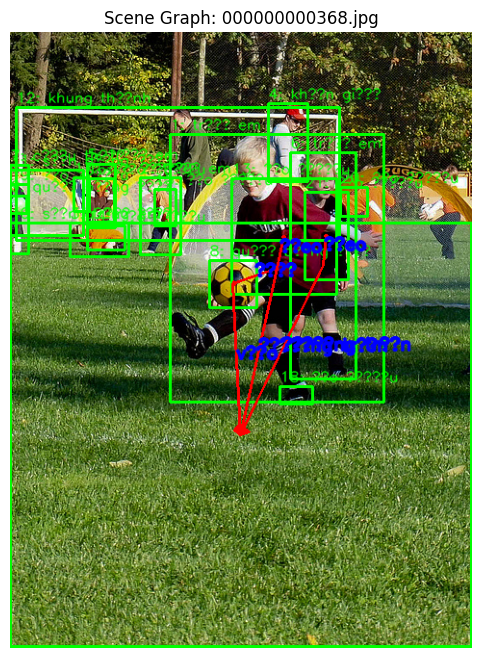

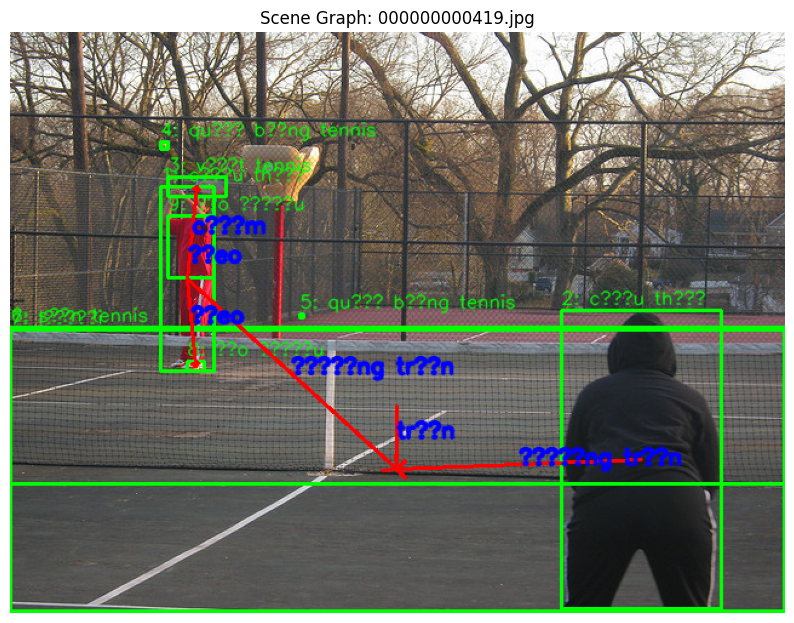

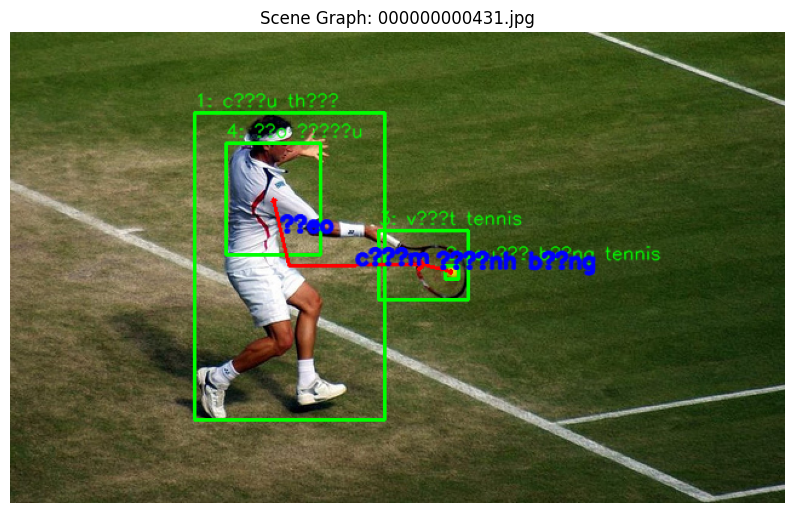

In [ ]:
import glob
import matplotlib.pyplot as plt

def _extract_image_id_and_name(ann):
    """Trả về (image_id:int|None, filename:str|None) từ annotation."""
    img_field = ann.get("image", ann.get("image_id", None))
    image_id = None
    filename = None

    if isinstance(img_field, int) or (isinstance(img_field, str) and img_field.isdigit()):
        image_id = int(img_field)
        filename = f"{image_id:012d}.jpg"  # chuẩn COCO: 12 chữ số
    elif isinstance(img_field, str):
        filename = img_field if img_field.lower().endswith(".jpg") else f"{img_field}.jpg"
        # cố gắng suy ra id từ tên file nếu là chuỗi 12 chữ số
        stem = os.path.splitext(os.path.basename(filename))[0]
        if stem.isdigit():
            try: image_id = int(stem)
            except: pass
    return image_id, filename

def find_image_path(image_root, ann):
    """Tìm đường dẫn ảnh theo cả filename và image_id (fallback glob)."""
    image_id, filename = _extract_image_id_and_name(ann)
    # 1) thử bằng filename
    if filename:
        p = os.path.join(image_root, filename)
        if os.path.exists(p):
            return p
    # 2) fallback theo image_id (glob đuôi số)
    if image_id is not None:
        # tìm file có đuôi ...{id}.jpg (phòng khi tên bị rút gọn)
        cand = glob.glob(os.path.join(image_root, f"*{image_id}.jpg"))
        if cand:
            return cand[0]
        # thử đúng format COCO
        p = os.path.join(image_root, f"{image_id:012d}.jpg")
        if os.path.exists(p):
            return p
    # 3) bó tay
    return None

def show_scenes(
    json_path,
    image_root,
    num_images=3,
    image_ids=None,        # ví dụ [368, 11015]
    filenames=None,        # ví dụ ["000000000368.jpg", "Bản sao của 000000011015.jpg"]
):
    """
    - Nếu truyền image_ids hoặc filenames: chỉ hiện đúng các ảnh đó (theo thứ tự lọc).
    - Ngược lại: hiện num_images ảnh đầu tiên.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        anns = json.load(f)

    # anns thường là list các annotation cho mỗi ảnh
    if not isinstance(anns, list) or len(anns) == 0:
        print("❌ Định dạng JSON không phải list hoặc rỗng.")
        return

    # Xây tập mục tiêu nếu người dùng truyền id/filename
    wanted_by_id = set(int(x) for x in (image_ids or []))
    wanted_by_name = set((filenames or []))

    shown = 0
    for ann in anns:
        # Lọc theo id/tên nếu có
        if wanted_by_id or wanted_by_name:
            img_id, fname = _extract_image_id_and_name(ann)
            ok = False
            if img_id is not None and img_id in wanted_by_id:
                ok = True
            if fname and fname in wanted_by_name:
                ok = True
            if not ok:
                continue
        else:
            # Không truyền danh sách cụ thể -> chỉ lấy num_images đầu
            if shown >= num_images:
                break

        img_path = find_image_path(image_root, ann)
        if not img_path:
            img_field = ann.get("image", ann.get("image_id", None))
            print(f"⚠️ Không tìm thấy ảnh tương ứng cho: {img_field}")
            continue

        # Vẽ scene (giữ nguyên hàm bạn đã có)
        img_drawn = draw_scene(img_path, ann)
        if img_drawn is None:
            print("⚠️ Không thể vẽ ảnh:", img_path)
            continue

        # Hiển thị
        img_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        title_name = os.path.basename(img_path)
        plt.imshow(img_rgb)
        plt.title(f"Scene Graph: {title_name}")
        plt.axis("off")
        plt.show()

        shown += 1

    if shown == 0:
        if wanted_by_id or wanted_by_name:
            print("❌ Không tìm thấy ảnh nào khớp danh sách được yêu cầu.")
        else:
            print("❌ Không hiển thị được ảnh nào.")

# ==========================
# Ví dụ chạy trực tiếp
# ==========================
def view_2():
    json_path = "/content/drive/MyDrive/VietSGG/relationships_vi_coco_uitvic_train.json"
    image_root = "/content/drive/MyDrive/VietSGG/uitvic_dataset/coco_uitvic_train/"

    # 1) Mặc định: hiện 3 ảnh đầu (khắc phục lỗi `for ann in anns[3]` -> phải là `anns[:3]`, nhưng đã gói trong show_scenes)
    show_scenes(json_path, image_root, num_images=3)

    # 2) Hoặc: hiện theo ID ảnh
    # show_scenes(json_path, image_root, image_ids=[368])

    # 3) Hoặc: hiện theo tên file ảnh
    # show_scenes(json_path, image_root, filenames=["000000000368.jpg"])

# Gọi thử
view_2()
